In [1]:
import requests
import json
import jwt
import uuid
import hashlib
from urllib.parse import urlencode
from cert import cert # certification key module

# market code 알아오는 코드
# market_info_url = "https://api.upbit.com/v1/market/all"
# market_codes = requests.get(market_info_url).json()
# print(market_codes) # 비트코인 : KRW-BTC, 이더리움 : KRW-ETH

# market codes list
kr_bit = 'KRW-BTC'
kr_eth = 'KRW-ETH'

# keys
access_key = cert.access_key
secret_key = cert.secret_key

# url
server_url = 'https://api.upbit.com/'

In [2]:
# candle : 분봉 정보
def candle(marketCode=kr_bit, candleType='minutes', candleUnit=5, candleCount=3):
    candle_url = server_url + f'v1/candles/{candleType}/{candleUnit}?market={marketCode}&count={candleCount}'
    res = requests.get(candle_url).json()
    print(json.dumps(res, indent=2))
    return res

In [3]:
def candle_day(marketCode, candleCount, last_datetime):
    candle_url = server_url + f'v1/candles/days?market={marketCode}&count={candleCount}&to={last_datetime}'
    res = requests.get(candle_url).json()
    # print(json.dumps(res, indent=2))
    return res

In [4]:
from datetime import date, timedelta

def last_datetime_cal(DateTime):
    year, month, day = int(DateTime[:4]), int(DateTime[5:7]), int(DateTime[8:10])
    datetime_datetime = date(year=year, month=month, day=day)
    delta = timedelta(days=1)
    new_datetime = datetime_datetime-delta
    return str(new_datetime)+'T09:00:00Z'

In [5]:
import pandas as pd
import numpy as np

last_close1 = np.nan
last_datetime = "2022-03-25T09:00:00Z"

res_df = pd.DataFrame()
for _ in range(8):
    candle = candle_day(kr_bit, 200, last_datetime)
    candle_df = pd.read_json(json.dumps(candle))
    candle_df = candle_df[['candle_date_time_kst', 'opening_price', 'high_price', 'low_price', 'prev_closing_price', 'candle_acc_trade_volume']]
    candle_df.columns=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    candle_df.set_index('DateTime', drop=True)
    last_close2 = candle_df['Close'][len(candle_df)-1]
    last_datetime = candle_df['DateTime'][len(candle_df)-1]+'Z'
    last_datetime = last_datetime_cal(last_datetime)
    candle_df['Close'] = candle_df.Close.shift(1)
    candle_df['Close'][0] = last_close1
    last_close1 = last_close2
    res_df = pd.concat([res_df, candle_df])
    res_df.reset_index(drop=True, inplace=True)

C:\Users\frank\AppData\Local\Temp/ipykernel_27848/2819572798.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candle_df['Close'][0] = last_close1


In [6]:
res_df.set_index('DateTime', inplace=True)
res_df.index = pd.to_datetime(res_df.index)
res_df.dropna(axis=0, inplace=True)

In [7]:
res_df

,Open,High,Low,Close,Volume
DateTime,,,,,
2022-03-24 09:00:00,52138000,53416000,51800000,52966000.0,7289.941854
2022-03-23 09:00:00,51689000,52232000,51118000,52138000.0,5293.402954
2022-03-22 09:00:00,50128000,52396000,50013000,51704000.0,8395.367481
2022-03-21 09:00:00,50471000,50756000,49832000,50128000.0,4418.715829
2022-03-20 09:00:00,51245000,51350000,50001000,50462000.0,4050.028652
...,...,...,...,...,...
2017-11-11 09:00:00,7541000,7897000,7009000,7231000.0,3407.257305
2017-11-10 09:00:00,8150000,8240000,7320000,7541000.0,3612.895643
2017-11-09 09:00:00,8338000,8340000,8041000,8148000.0,2491.809101


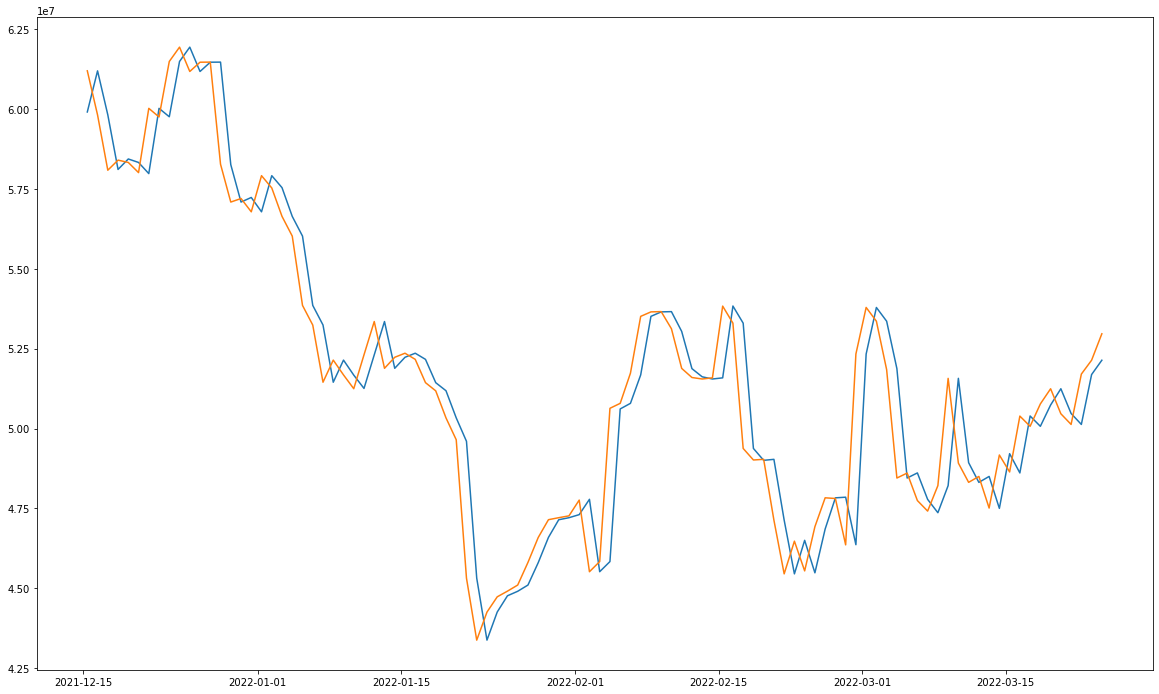

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(res_df[['Open', 'Close']][:100])
plt.show()